<a href="https://colab.research.google.com/github/AdeelH/tl-experiments/blob/master/semantic_segmentation_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Fri Jul 12 02:26:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    17W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
!pip install rasterio

     |████████████████████████████████| 19.7MB 27.3MB/s 


In [0]:
import os
from pathlib import Path
from glob import glob
import copy

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils
import torchvision as tv
from torchvision import transforms as tf

from fastai.vision import *
from fastai.metrics import error_rate

from PIL import Image
import rasterio
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Data

In [0]:
import pickle

from google.colab import drive
drive.mount('/content/gdrive')


with open('/content/gdrive/My Drive/potsdam/potsdam.pkl', 'rb') as f:
    potsdam_dict = pickle.load(f)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
identity = lambda x: x

class Potsdam(tv.datasets.VisionDataset):
    
    def __init__(self, d, chip_size=100, stride=1, tf=identity, x_tf=identity, y_tf=identity):
        super(Potsdam).__init__()

        self.data = list(d.values())
        self.fnames = list(d.keys())

        self.n = len(d)
        self.chip_size = chip_size

        im_size = self.data[0][2].shape
        self.h = ((im_size[0] - chip_size) // stride) + 1
        self.w = ((im_size[1] - chip_size) // stride) + 1

        self.tf, self.x_tf, self.y_tf = tf, x_tf, y_tf


    def __len__(self):
        return self.n * self.w * self.h
    
    def __getitem__(self, i):
        if isinstance(i, (int, np.integer)):
            return self._load(i)
        if isinstance(i, np.ndarray) or isinstance(i, torch.Tensor):
            i = i.squeeze()
            assert i.ndim in (0, 1), "too many dimensions"
            if i.ndim == 0:
                return self._load(i)
            return [self._load(j) for j in i]
        if isinstance(i, slice):
            return [self._load(j) for j in range(*i.indices(len(self.fnames)))]
        assert False, f"__getitem__(i): Invalid index"
        
    def _to_chip_idx(self, i):
        im_idx = i // (self.w * self.h)
        im_i = i % (self.w * self.h)
        chip_col = im_i % self.w
        chip_row = im_i // self.h
        return im_idx, chip_row, chip_col

    def _load(self, i):
        im_idx, chip_row, chip_col = self._to_chip_idx(i)
        rgbir, elevation, label  = self.data[im_idx]
        
        x_start, x_end = chip_col, chip_col + self.chip_size
        y_start, y_end = chip_row, chip_row + self.chip_size

        rgbir_chip     = rgbir[:,  y_start : y_end, x_start : x_end]
        elevation_chip = elevation[y_start : y_end, x_start : x_end]
        label_chip     = label[    y_start : y_end, x_start : x_end]

        x = torch.cat((rgbir_chip, elevation_chip.unsqueeze(0)), dim=0).float() / 255

        x, y = self.tf((x, label_chip))

        return self.x_tf(x), self.y_tf(y)


## Transforms

In [0]:
class Downsample(object):
    def __init__(self, factor):
        self.factor = factor
    
    def __call__(self, arrs):
        return [np.ascontiguousarray(a[..., ::self.factor, ::self.factor]) for a in arrs]
    
    def __repr__(self):
        return self.__class__.__name__ + f'(factor={self.factor})'


class RandomFlip(object):
    def __init__(self, h_prob=0.5, v_prob=0.5):
        self.h_prob = h_prob
        self.v_prob = v_prob
    
    def __call__(self, arrs):
        if torch.rand(1) < self.v_prob:
            arrs = [arr.flip(-2) for arr in arrs]
        if torch.rand(1) < self.h_prob:
            arrs = [arr.flip(-1) for arr in arrs]
        return arrs

    def __repr__(self):
        return self.__class__.__name__ + f'(h_prob={self.h_prob}, v_prob={self.v_prob})'


class ChannelSelect(object):
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, arr):
        return arr[self.channels]

    def __repr__(self):
        return self.__class__.__name__ + f'(channels={self.channels})'
    


In [0]:
channels = [4]

train_transform = tf.Compose([
    Downsample(2),
    tf.Lambda(lambda xs: [torch.tensor(x) for x in xs]),
    RandomFlip(),
])

val_transform = tf.Compose([
    Downsample(2),
    tf.Lambda(lambda xs: [torch.tensor(x) for x in xs]),
])

x_transform = tf.Compose([
    ChannelSelect(channels)
])

y_transform = tf.Compose([
    tf.Lambda(lambda x: x.long())
])


## Create datasets

In [0]:
original = Potsdam(potsdam_dict, chip_size=400, stride=200, tf=val_transform)

train_ds = Potsdam(potsdam_dict, chip_size=400, stride=200, tf=train_transform, x_tf=x_transform, y_tf=y_transform)
val_ds   = Potsdam(potsdam_dict, chip_size=400, stride=200, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)

In [0]:
len(val_ds)

15138

In [0]:
plt.imshow(original[10020][0][0])
plt.show()

plt.imshow(original[10020][0][1])
plt.show()

plt.imshow(original[10020][0][2])
plt.show()

plt.imshow(original[10020][0][3])
plt.show()

plt.imshow(original[10020][0][:3].permute(1, 2, 0))
plt.show()

In [0]:
plt.imshow(val_ds[10020][0].squeeze())
plt.show()

plt.imshow(val_ds[10020][1])
plt.show()

In [0]:
for rgbir, el, lab in original.data:
    plt.figure(figsize=(4, 4))
    plt.imshow(rgbir.permute(1, 2, 0)[..., :3])
    plt.show()

## Split into train and validation sets using `SubsetRandomSampler()`

In [0]:
train_split_size = int(len(train_ds) * .85 // 1)
val_split_size = len(train_ds) - train_split_size
train_split_size, val_split_size

print('train_split_size', train_split_size)
print('val_split_size', val_split_size)

inds = np.arange(len(train_ds))
np.random.shuffle(inds)

train_split_size 12867
val_split_size 2271


In [0]:
train_sampler = torch.utils.data.SubsetRandomSampler(inds[:train_split_size])
val_sampler = torch.utils.data.SubsetRandomSampler(inds[train_split_size:])

assert len(set(train_sampler.indices) & set(val_sampler.indices)) == 0

# Model

## Use FastAI to create a UNet from a modified Resnet18

The modified Resnet18 has a 1-channel (instead of the normal 3-channel) first conv layer.

In [0]:
def _base_model(pretrained=False):
    m = tv.models.resnet18(pretrained=pretrained)
    m._modules['conv1'] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    for c in m.children():
        for p in c.parameters():
            p.requires_grad = False
            p.grad = None
    
    for p in m._modules['conv1'].parameters():
        p.requires_grad = True

    return m


In [0]:
model = models.unet.DynamicUnet(create_body(_base_model, pretrained=True), n_classes=6, last_cross=False).cuda()
model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 28218316.95it/s]


DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [0]:
# model = tv.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=6).cuda()
# model = torch.hub.load('pytorch/vision', 'deeplabv3_resnet101', pretrained=True)

In [0]:
for c in model.layers[1:].children():
    for p in c.parameters():
        print(p.requires_grad, c)

In [0]:
model.eval()
with torch.no_grad():
    print(model(val_im)['out'].shape)

## Load weights from file

In [0]:
def load_weights(model_save_name, model):
    from google.colab import drive
    drive.mount('/content/gdrive')
    
    path = F"/content/gdrive/My Drive/potsdam/models/{model_save_name}"
    state = torch.load(path)
    print(state['info'])
    model.load_state_dict(state['model'])

load_weights('resnet18p_elevation_200x200_7x7_enc_frozen_lc_false', model)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
{'acc': tensor(0.9862), 'epoch': 15, 'val_loss': tensor(0.0357), 'lr': 0.035203658778440124}


# Training

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

def save_model(model, name, info={}):
    state = {
        'model': model.state_dict(),
        'info': info
    }
    path = F"/content/gdrive/My Drive/potsdam/models/{name}" 
    torch.save(state, path)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Define training loop

In [0]:
import time

    
def replace_zeros(t, val=1):
    t[t == 0] = val
    return t

def fbeta(precision, recall, beta=2):
    beta2 = beta ** 2
    return (1 + beta2) * (precision * recall) / ((beta2 * precision) + recall)

def validate(model, criterion, val_dl, nclasses):

    loss = 0.
    conf_matrix = torch.zeros((nclasses, nclasses))
    classes = torch.arange(nclasses)

    torch.cuda.empty_cache()
    model.eval()
    with torch.no_grad():
        for i, (batch, labels) in enumerate(val_dl):
            N = batch.shape[0]
            batch = batch.cuda()
            labels = labels.view(-1)

            preds = model(batch).detach().cpu().permute(0, 2, 3, 1).contiguous()
            preds = preds.view(-1, preds.shape[-1])

            loss += criterion(preds, labels)
            preds = preds.argmax(dim=-1)
            conf_matrix += ((preds == classes[:, None]) & (labels == classes[:, None, None])).sum(dim=2).float()
            break

    acc = conf_matrix.trace() / conf_matrix.sum()
    class_precision = conf_matrix.diag() / replace_zeros(conf_matrix.sum(dim=0))
    class_recall = conf_matrix.diag() / replace_zeros(conf_matrix.sum(dim=1))
    class_f_score = fbeta(class_precision, class_recall, beta=2)
    
    # weighted sum over classes
    weights = conf_matrix.sum(dim=1) / conf_matrix.sum()
    precision = (weights * class_precision).sum()
    recall = (weights * class_recall).sum()
    f_score = fbeta(precision, recall, beta=2)
    
    return loss, (acc, precision, recall, f_score), (class_precision, class_recall, class_f_score)


def train_epoch(model, train_dl, criterion, optimizer):
    
    loss = 0.
    corrects = 0
    count = 0

    model.train()
    for i, (batch, labels) in enumerate(train_dl):
        N = batch.shape[0]
        batch = batch.cuda()
        labels = labels.view(-1).cuda()

        preds = model(batch).permute(0, 2, 3, 1).contiguous()
        preds = preds.view(-1, preds.shape[-1])
        
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss += loss.detach().cpu()
        corrects += (preds.argmax(dim=-1) == labels).detach().cpu().sum()
        count += len(labels)

    acc = corrects.float() / count
    
    return loss, acc


def train_seg(model, train_dl, val_dl, optimizer, sched, params, criterion=nn.CrossEntropyLoss(), callback=lambda x: None, save_name='model', best_acc=0.85):
    '''Train a classification model.
    
    Args:
        - model: The model to be trained (must be a `nn.Module`).
        - train_dl: A `torch.utils.data.Dataloader` for training data.
        - val_dl: A `torch.utils.data.Dataloader` for validation data.
        - optimizer: The optimizer to use for training.
        - sched: The LR scheduler to use for training. `sched.step()` will be called after each epoch.
        - params: Additional training parameters.
        - criterion: Loss function.
        - callback: A callback that is called at the end of each epoch.
        - save_name: Filename to use for saving the model.
        - best_acc: Initial value for best-accuracy-so-far.
    '''

    torch.cuda.empty_cache()
    for epoch in range(params['epochs']):
        
        start_time = time.time()

        # train (fwd pass and backprop)
        epoch_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer)

        # validate
        val_loss, val_metrics, val_class_metrics = validate(model, criterion, val_dl, 6)
        val_acc = val_metrics[0]

        # save best model so far
        # save only if there is an improvement of >=0.05%
        if val_acc >= (best_acc + 0.005):
            best_acc = val_acc
            info = {'acc': val_acc, 'epoch': epoch, 'val_loss': val_loss, 'lr': optimizer.param_groups[0]['lr']}
            save_model(model, save_name, info=info)

        print('> epoch: %3d, lr: %0.8f, epoch_loss: %4.4f, val_loss: %4.4f, train_acc: %0.4f, val_acc: %0.4f, best: %0.4f, time: %0.1f s' % \
              (epoch, optimizer.param_groups[0]['lr'], epoch_loss, val_loss, train_acc, val_acc, best_acc, time.time() - start_time))
        print('overall stats: acc: %.4f, precision: %.4f, recall: %.4f, f_score: %.4f' % val_metrics)
        cm = val_class_metrics
        for i in range(6):
            print('class: %d: precision: %.4f, recall: %.4f, f_score: %.4f' % (i, cm[0][i], cm[1][i], cm[2][i]))
        print()
        sched.step()
        callback(model)


## Train

In [0]:
train_params = {}
train_params['batch_size'] = 32
train_params['val_batch_size'] = 64

In [0]:
train_dl = torch.utils.data.DataLoader(train_ds, sampler=train_sampler, batch_size=train_params['batch_size']    , pin_memory=False, num_workers=4)
val_dl   = torch.utils.data.DataLoader(val_ds  , sampler=val_sampler  , batch_size=train_params['val_batch_size'], pin_memory=False, num_workers=4)

In [0]:

train_params = {}
train_params['epochs'] = 25
train_params['learning_rate'] = 1e-1
train_params['learning_rate_min'] = 1e-3

train_params['model_save_name'] = 'resnet18p_elevation_200x200_7x7_enc_frozen_lc_false'

optimizer = optim.SGD(model.parameters(), lr=train_params['learning_rate'], momentum=0.9, weight_decay=5e-4)

sched = optim.lr_scheduler.CosineAnnealingLR(optimizer, train_params['epochs'], eta_min=train_params['learning_rate_min'])

train_seg(model, train_dl, val_dl, optimizer, sched, train_params, save_name=train_params['model_save_name'], best_acc=0.85)


> epoch:   0, lr: 0.10000000, epoch_loss: 1.9048, val_loss: 1.6088, train_acc: 0.9750, val_acc: 0.5816, best: 0.8500, time: 239.5 s
overall stats: acc: 0.5816, precision: 0.6253, recall: 0.5816, f_score: 0.5899
class: 0: precision: 0.6127, recall: 0.2616, f_score: 0.2955
class: 1: precision: 0.4239, recall: 0.7867, f_score: 0.6717
class: 2: precision: 0.7337, recall: 0.5724, f_score: 0.5987
class: 3: precision: 0.2527, recall: 0.3860, f_score: 0.3492
class: 4: precision: 0.8052, recall: 0.0545, f_score: 0.0670
class: 5: precision: 0.6800, recall: 0.7147, f_score: 0.7075

> epoch:   1, lr: 0.09960968, epoch_loss: 0.2577, val_loss: 0.2281, train_acc: 0.9558, val_acc: 0.9375, best: 0.9375, time: 244.6 s
overall stats: acc: 0.9375, precision: 0.9457, recall: 0.9375, f_score: 0.9391
class: 0: precision: 0.7409, recall: 0.9846, f_score: 0.9238
class: 1: precision: 0.9792, recall: 0.8063, f_score: 0.8358
class: 2: precision: 0.9551, recall: 0.9824, f_score: 0.9768
class: 3: precision: 0.9629,

In [0]:
val_iter = (iter(val_sampler))

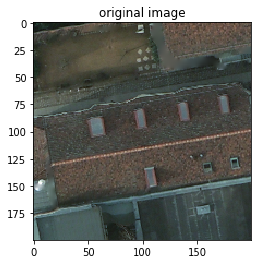

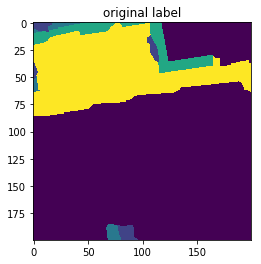

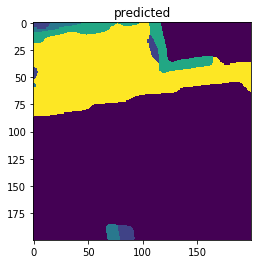

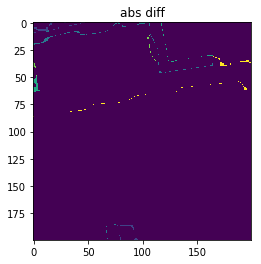

In [0]:
i = next(val_iter)

model.eval()
with torch.no_grad():
    x = val_ds[i][0].unsqueeze(0).cuda()
    out = model(x)

yhat = out.cpu().squeeze().permute(1, 2, 0).argmax(dim=-1)
y = val_ds[i][1]

plt.imshow(original[i][0][:3].permute(1, 2, 0))
plt.title(f'original image')
plt.show()

# plt.imshow(val_ds[i][0].squeeze())
# plt.title(f'elevation (log)')
# plt.show()

plt.imshow(y)
plt.title(f'original label')
plt.show()

plt.imshow(yhat)
plt.title(f'predicted')
plt.show()

plt.imshow((val_ds[i][1] - yhat).abs())
plt.title(f'abs diff')
plt.show()



# Visualize first conv layer filters

In [0]:
model[0][0].weight.grad.data.abs().mean()

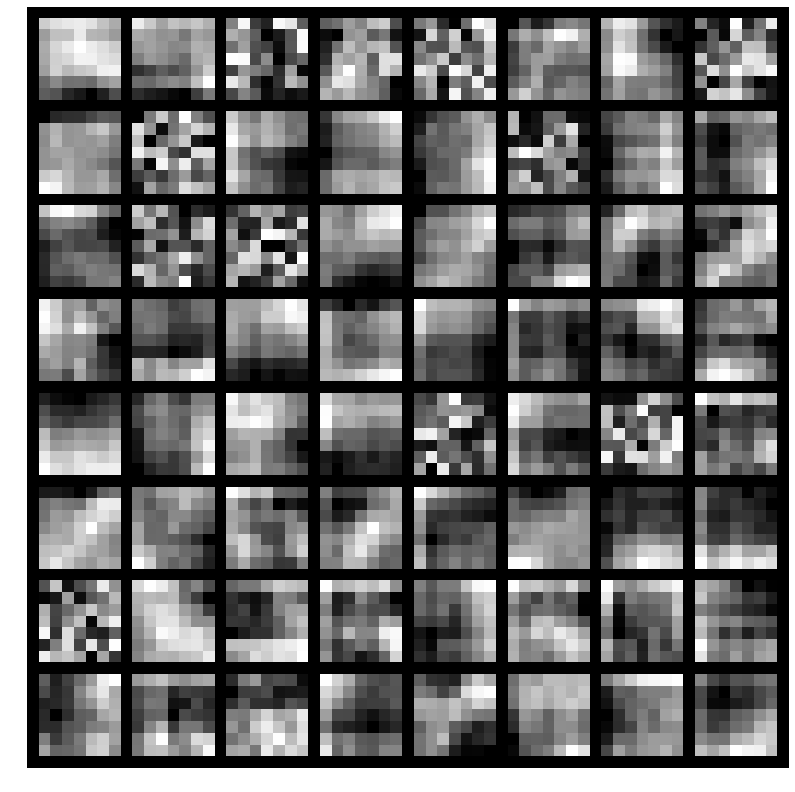

In [0]:
def viz_filters(conv_layer, normalize=True, scale_each=True):
    fs = conv_layer.weight.data.clone().detach().cpu()
    grid = tv.utils.make_grid(fs, normalize=normalize, scale_each=scale_each, padding=1).permute(1, 2, 0)

    plt.figure(figsize=(14, 14))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

viz_filters(model[0][0], normalize=True, scale_each=True)

In [0]:
list(model.children())


------------------------------------------- Input image -------------------------------------------



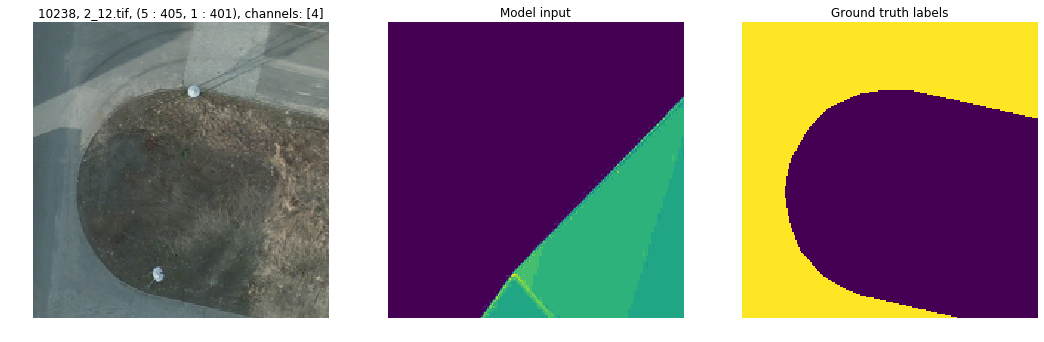


------------------------------------------- Layer-wise output -------------------------------------------

Layer: Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Output shape: torch.Size([64, 1, 100, 100])


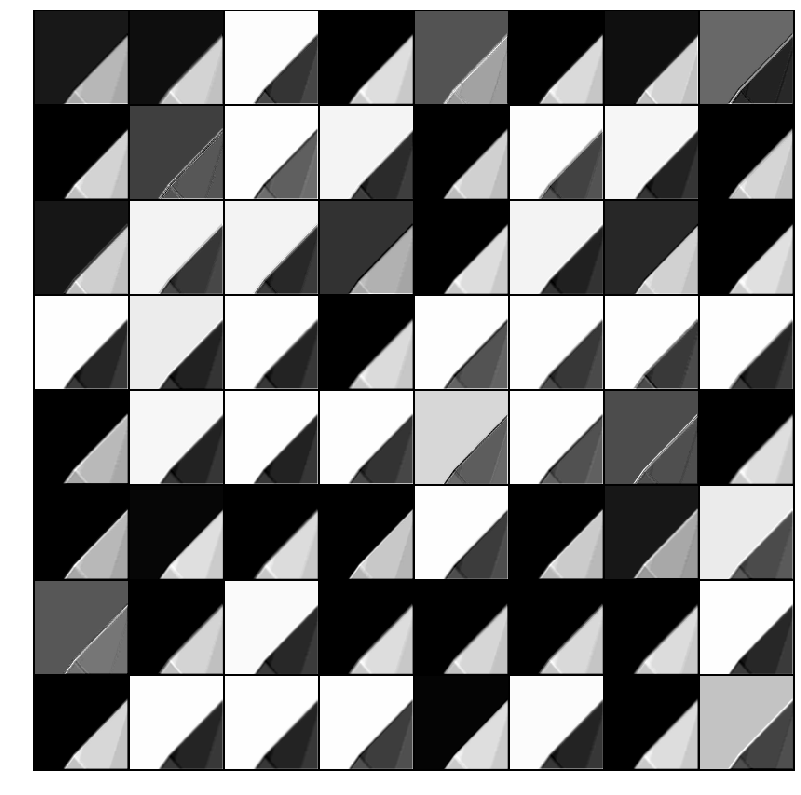

Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([64, 1, 100, 100])


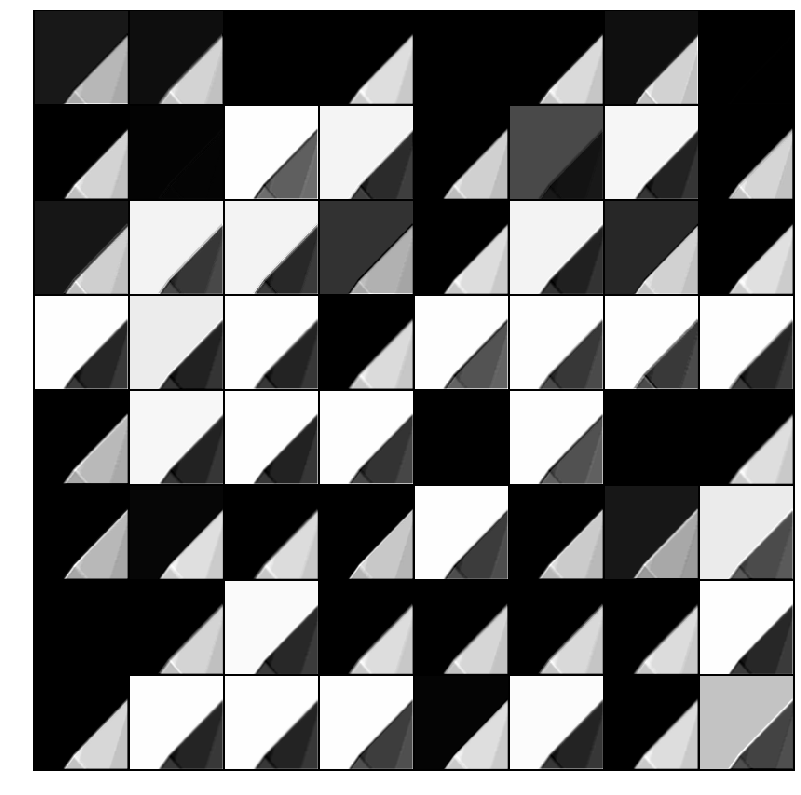

Layer: ReLU(inplace)
Output shape: torch.Size([64, 1, 100, 100])


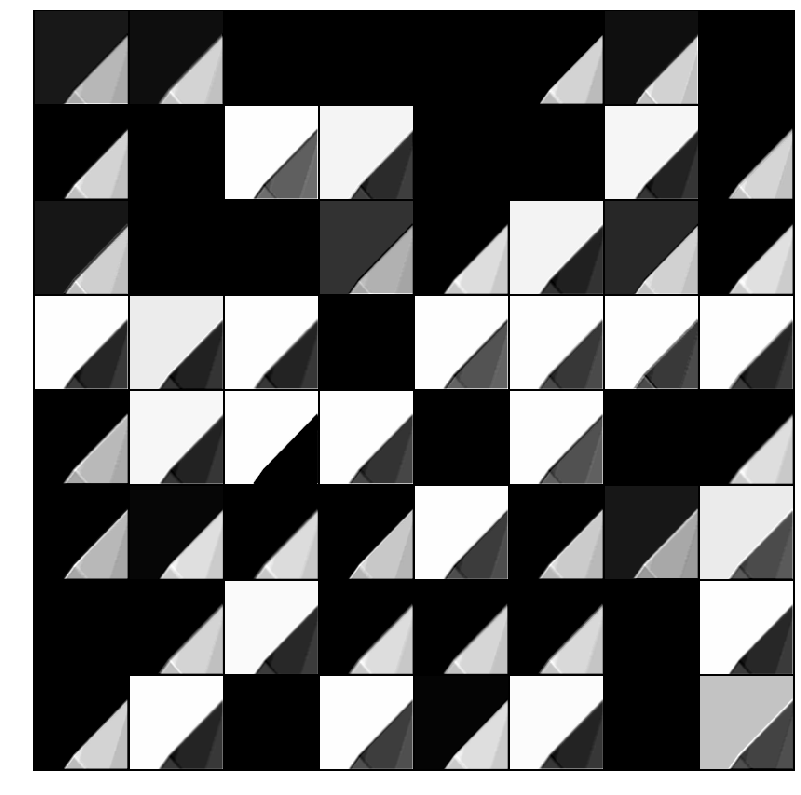

Layer: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Output shape: torch.Size([64, 1, 50, 50])


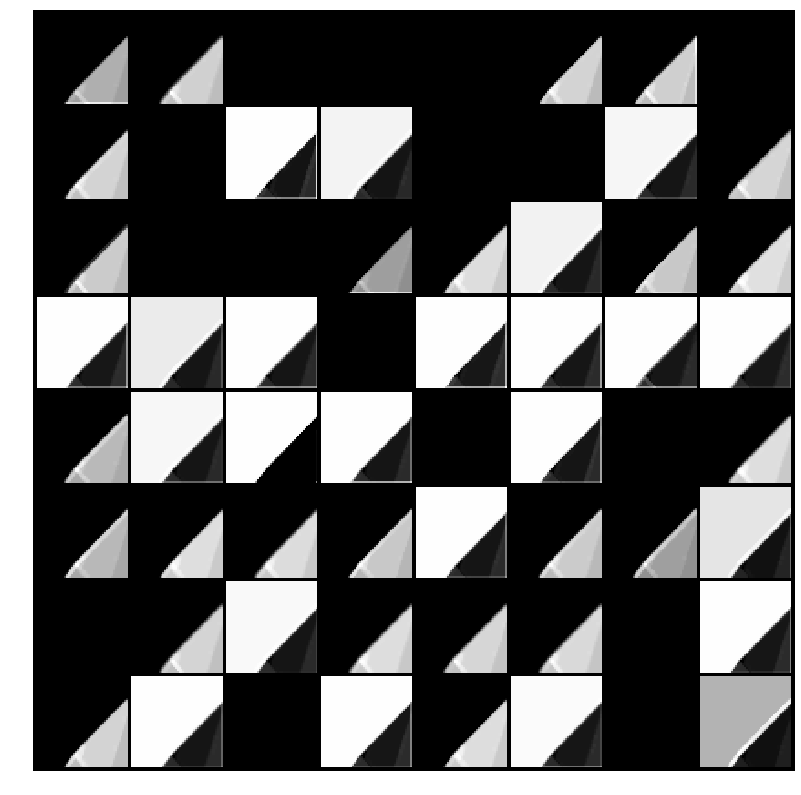

Layer: BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output shape: torch.Size([64, 1, 50, 50])


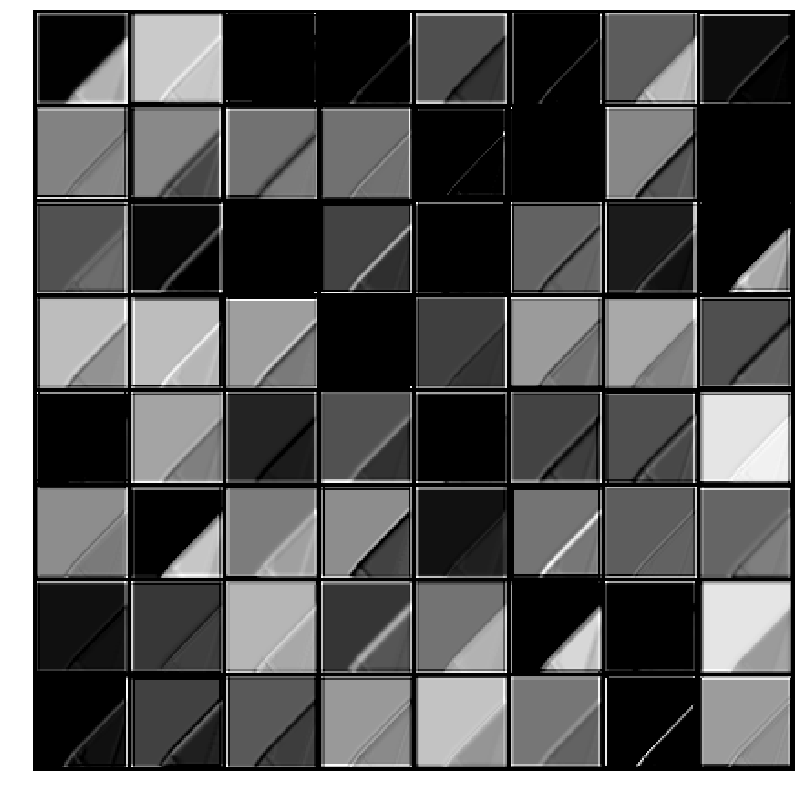

Layer: BasicBlock(
  (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output shape: torch.Size([64, 1, 50, 50])


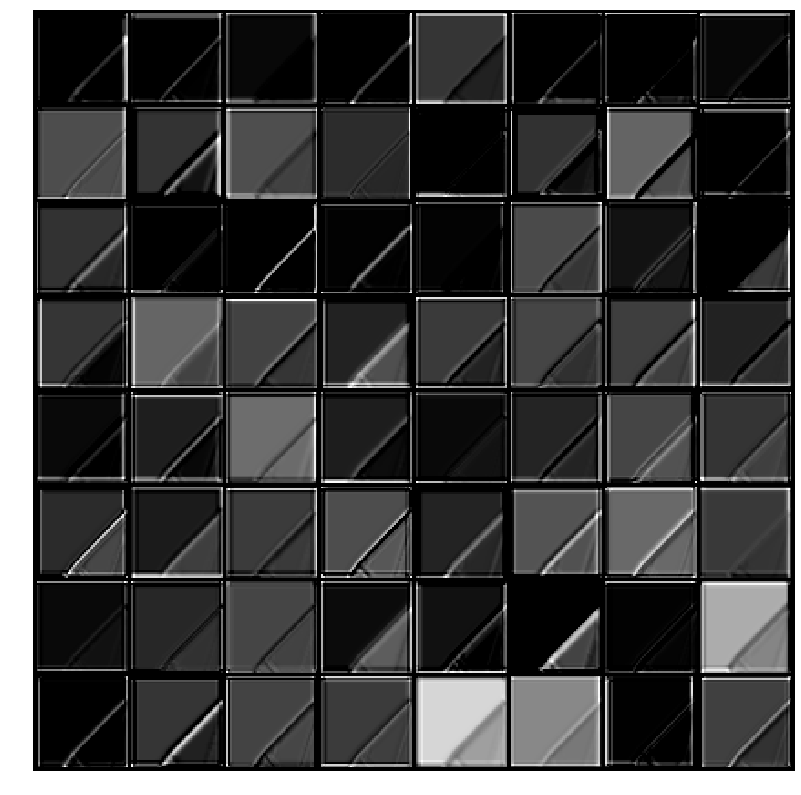

Layer: BasicBlock(
  (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Output shape: torch.Size([128, 1, 25, 25])


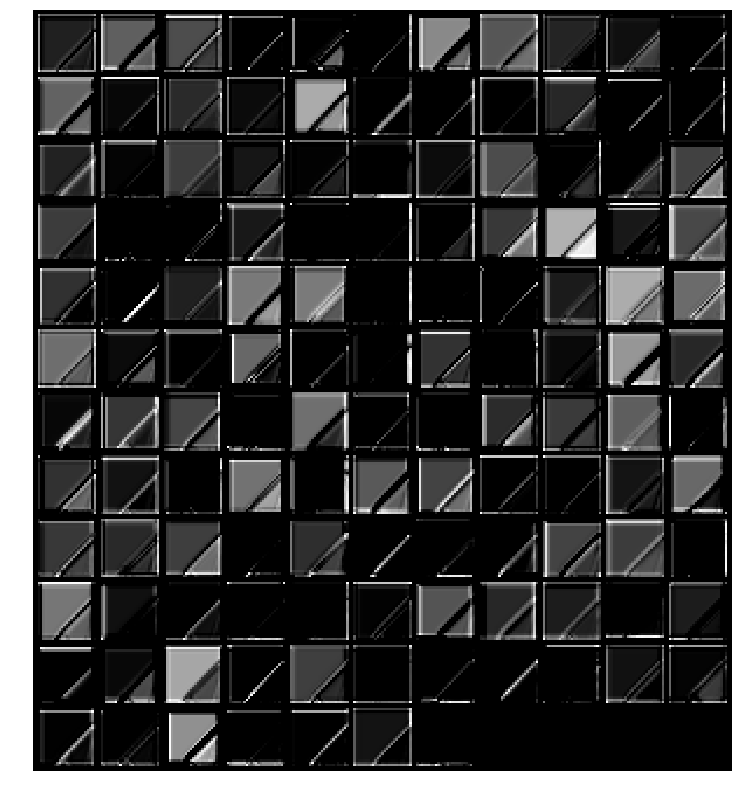

Layer: BasicBlock(
  (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output shape: torch.Size([128, 1, 25, 25])


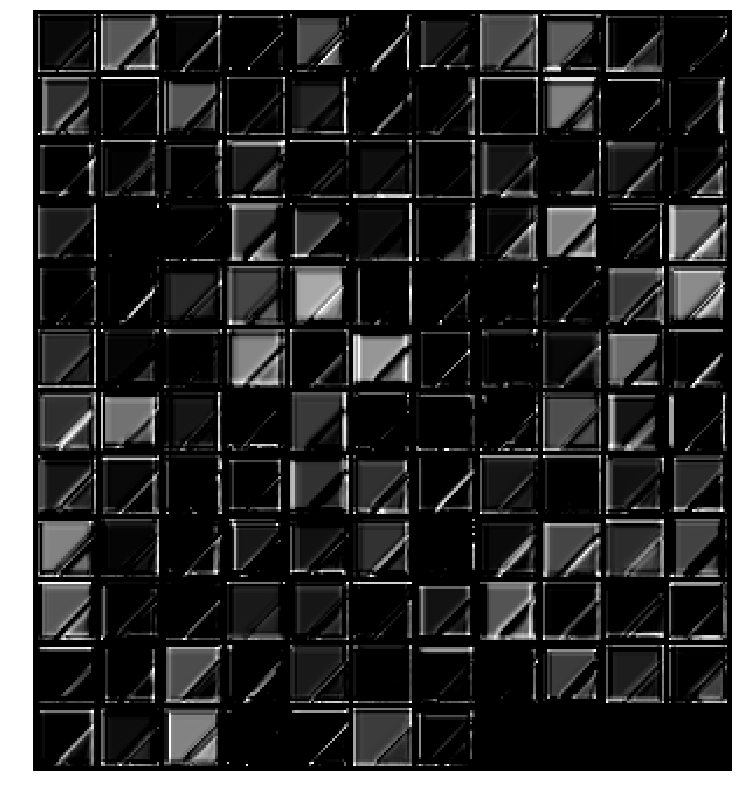

Layer: BasicBlock(
  (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Output shape: torch.Size([256, 1, 13, 13])


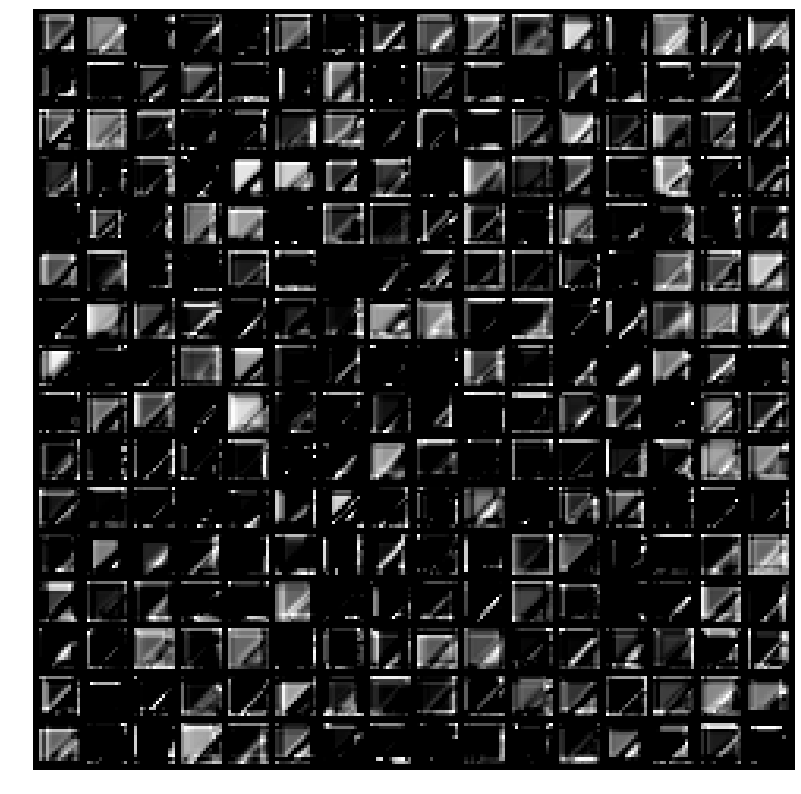

Layer: BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output shape: torch.Size([256, 1, 13, 13])


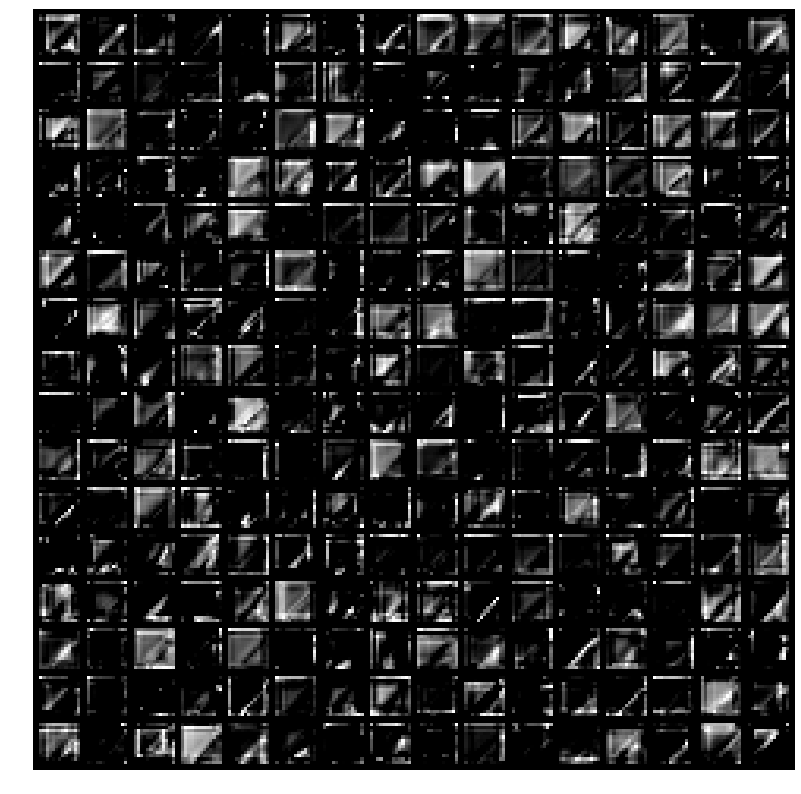

Layer: BasicBlock(
  (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (downsample): Sequential(
    (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
Output shape: torch.Size([512, 1, 7, 7])


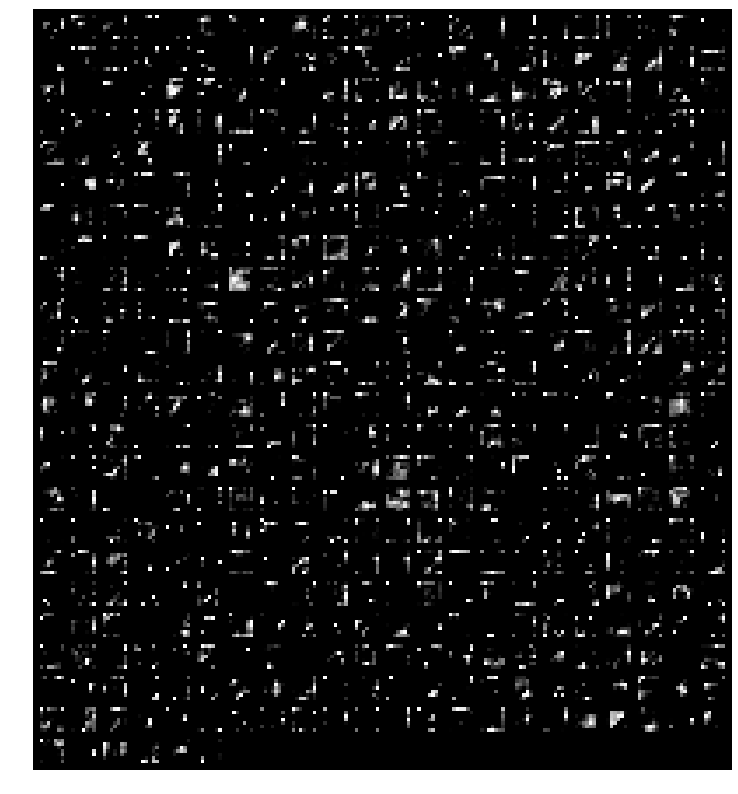

Layer: BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Output shape: torch.Size([512, 1, 7, 7])


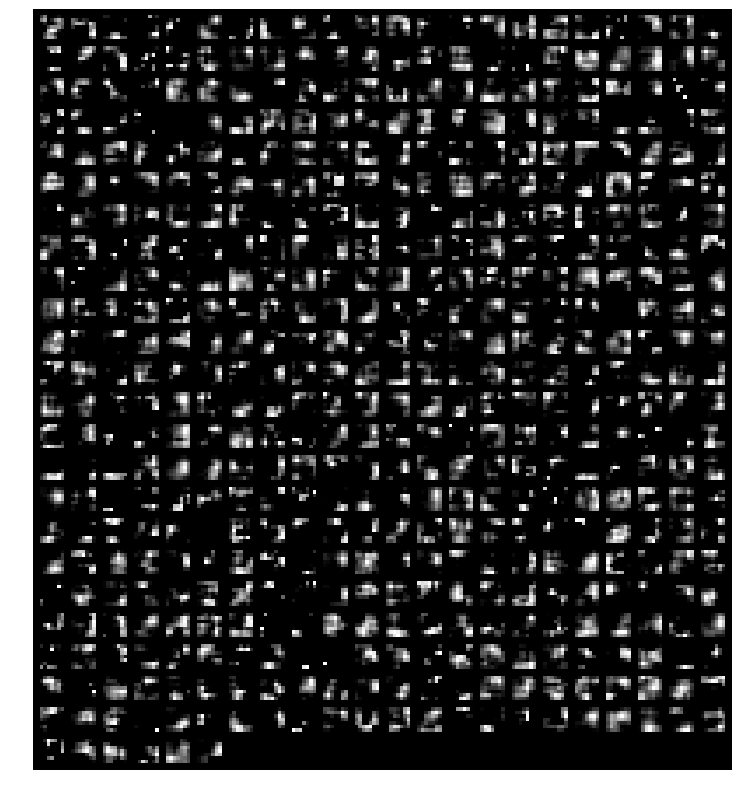

Layer: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([512, 1, 7, 7])


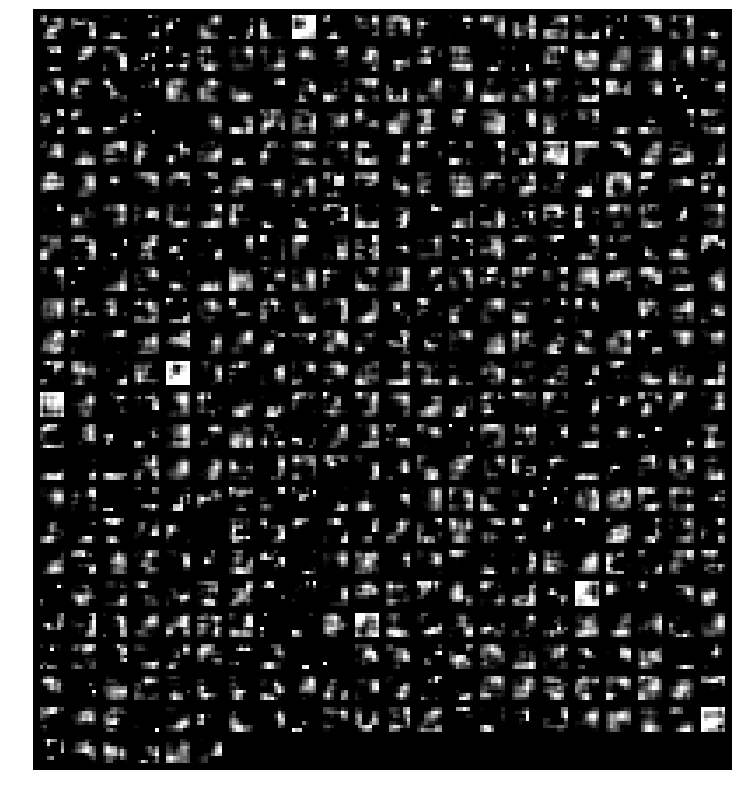

Layer: ReLU()
Output shape: torch.Size([512, 1, 7, 7])


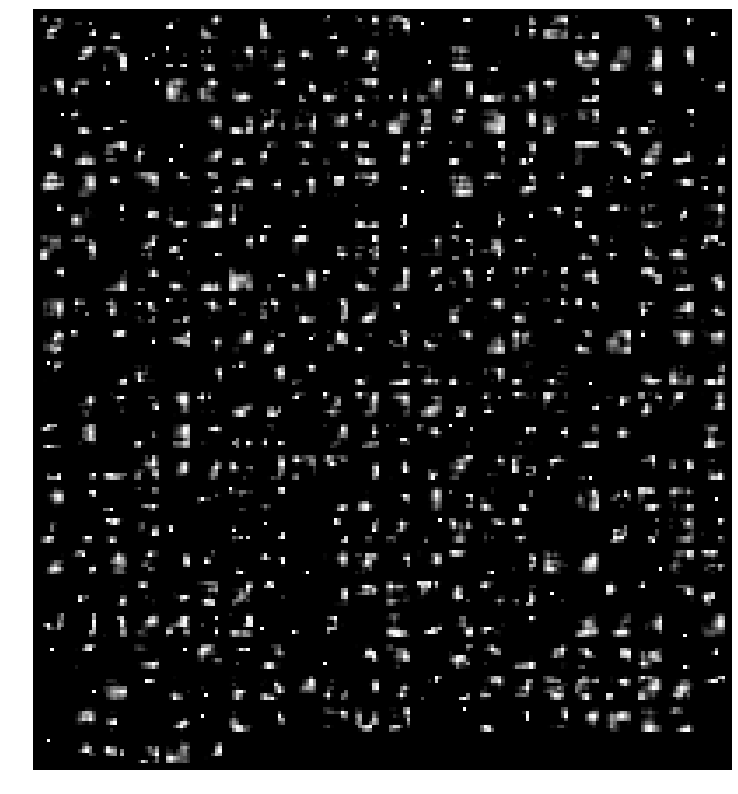

Layer: Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output shape: torch.Size([1024, 1, 7, 7])


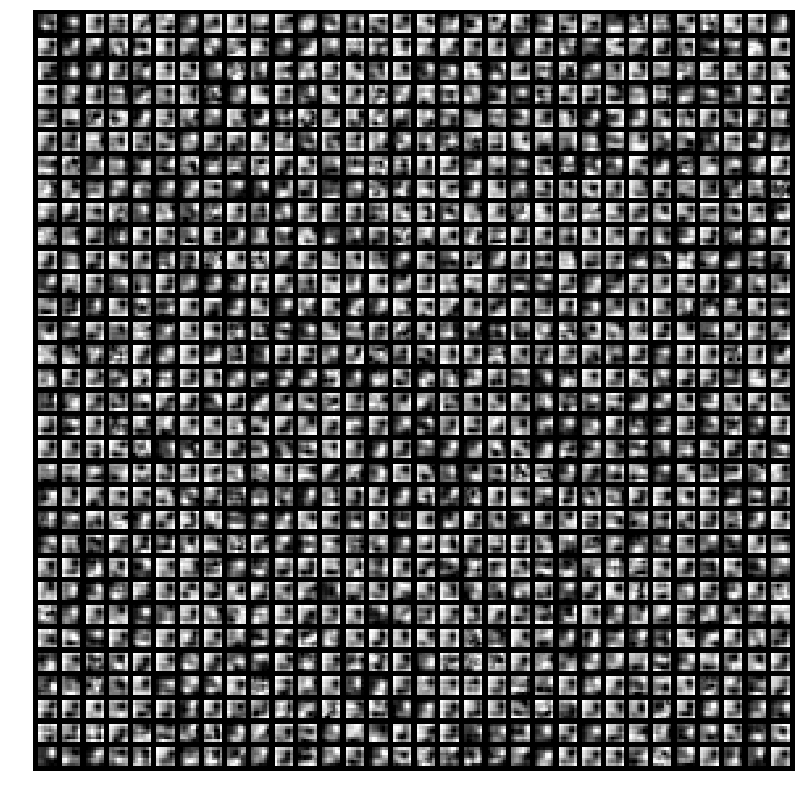

Layer: ReLU(inplace)
Output shape: torch.Size([1024, 1, 7, 7])


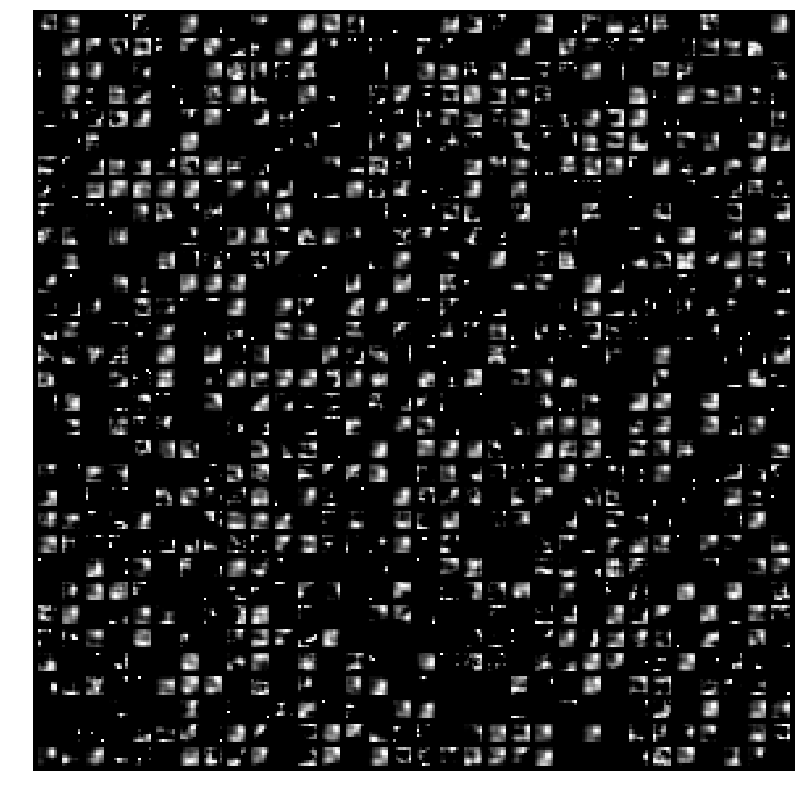

Layer: BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([1024, 1, 7, 7])


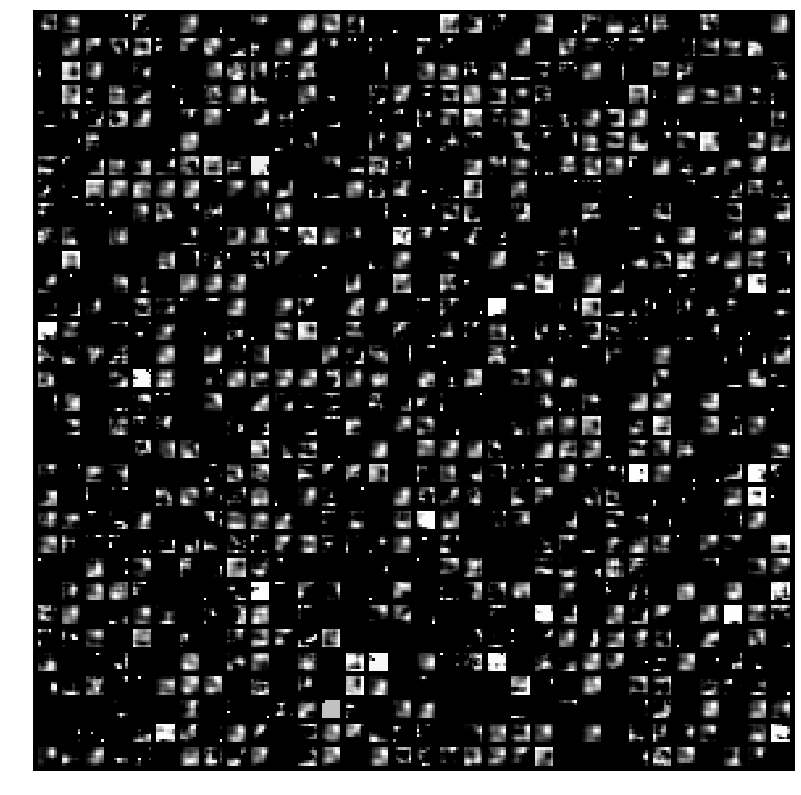

Layer: Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Output shape: torch.Size([512, 1, 7, 7])


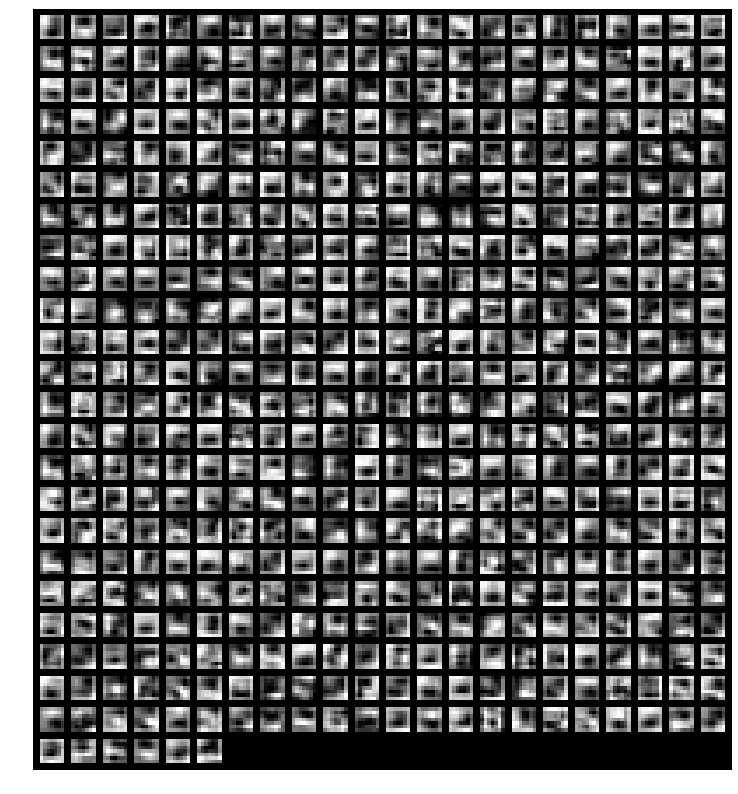

Layer: ReLU(inplace)
Output shape: torch.Size([512, 1, 7, 7])


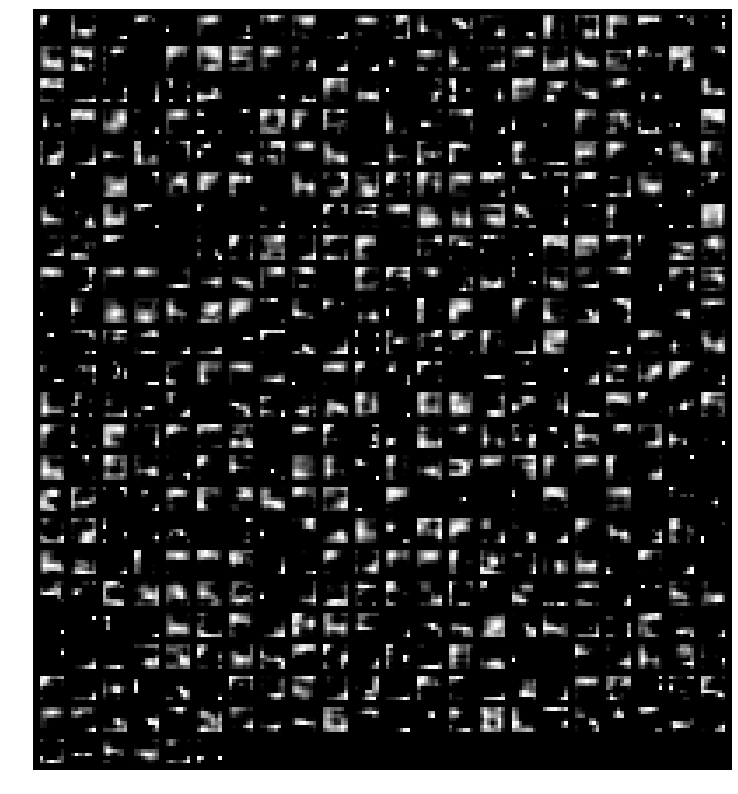

Layer: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([512, 1, 7, 7])


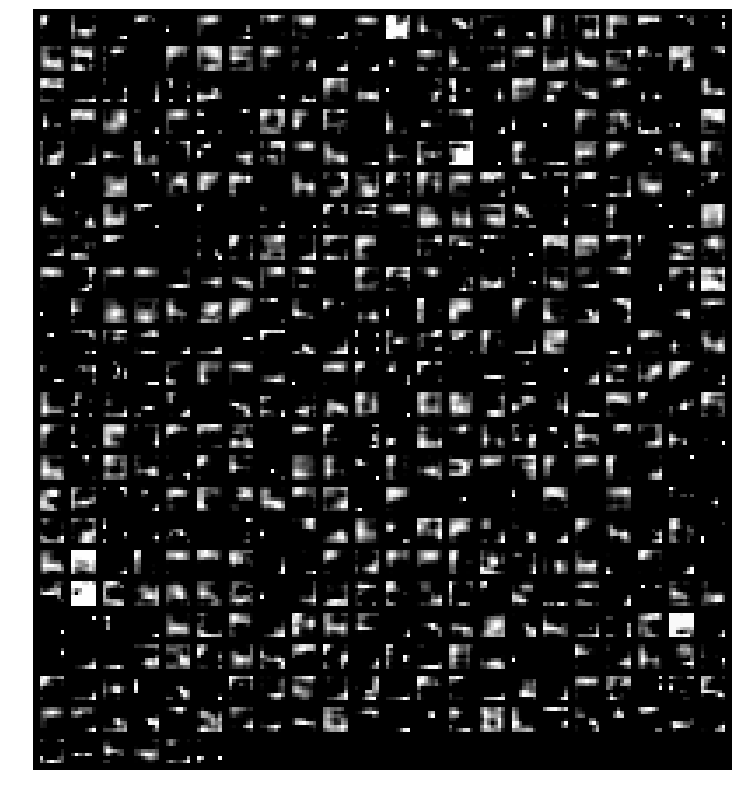

Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([512, 1, 13, 13])


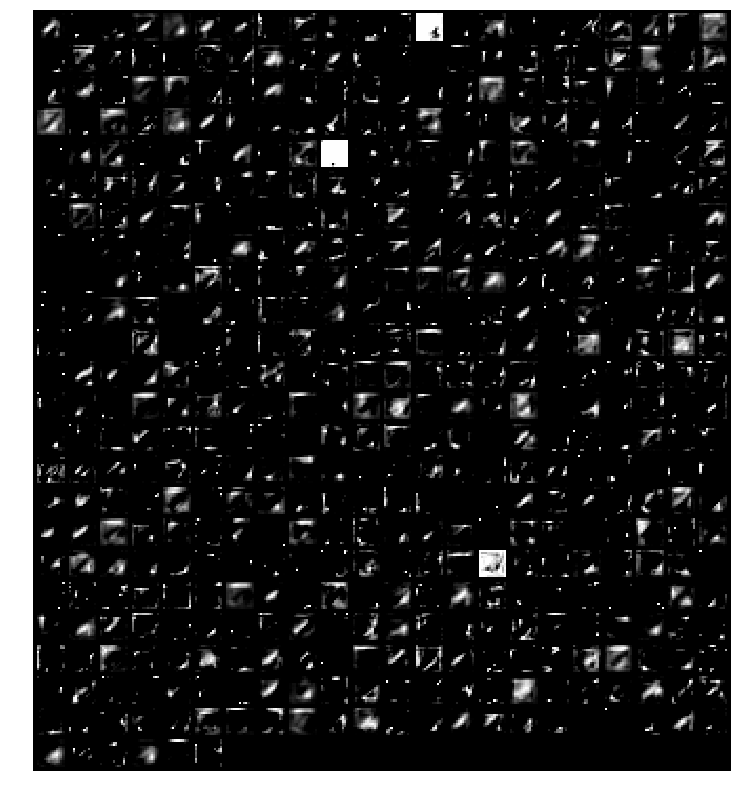

Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([384, 1, 25, 25])


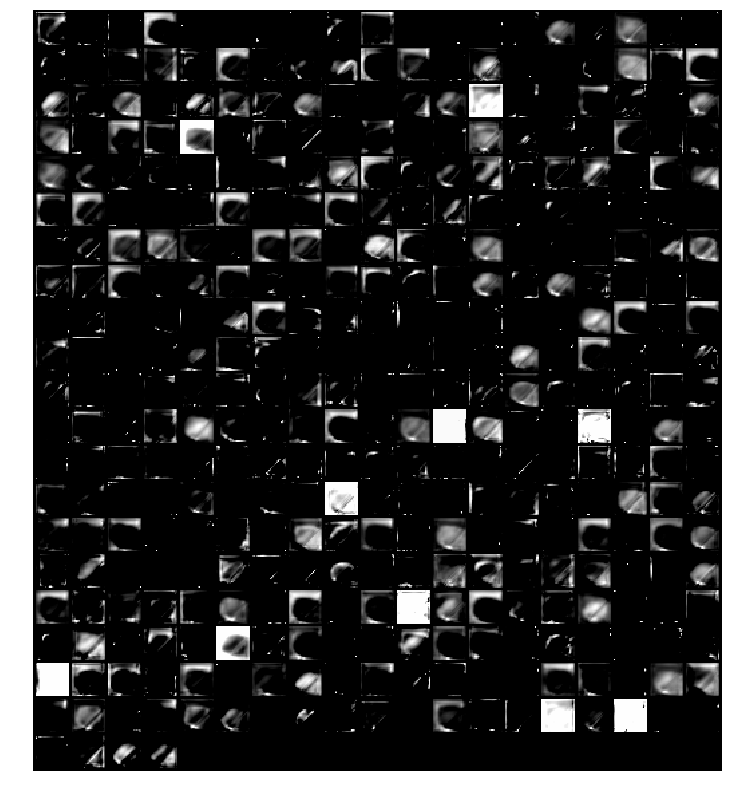

Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(384, 768, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([256, 1, 50, 50])


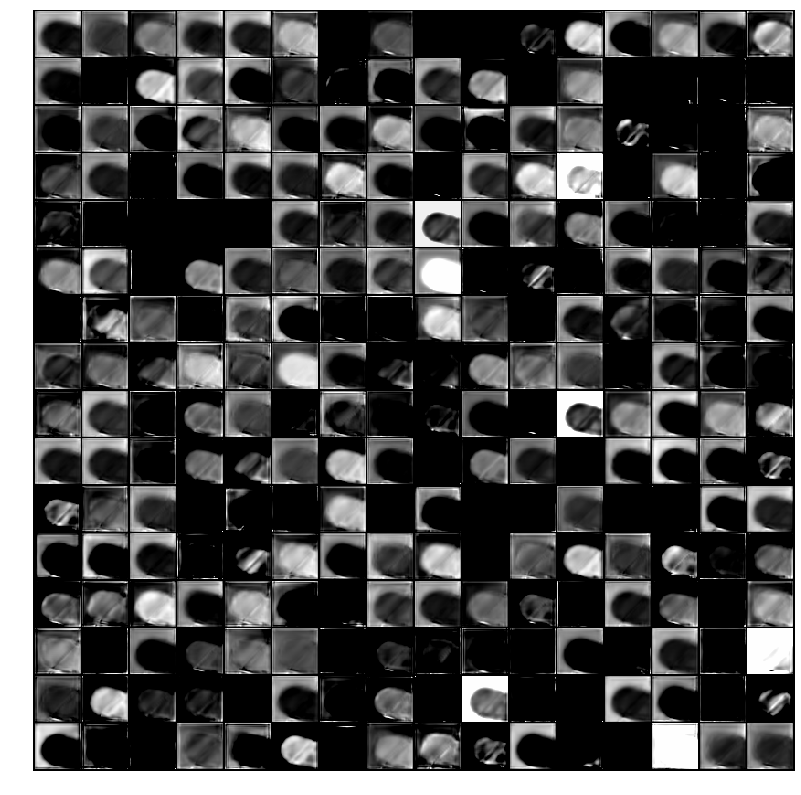

Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(192, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([96, 1, 100, 100])


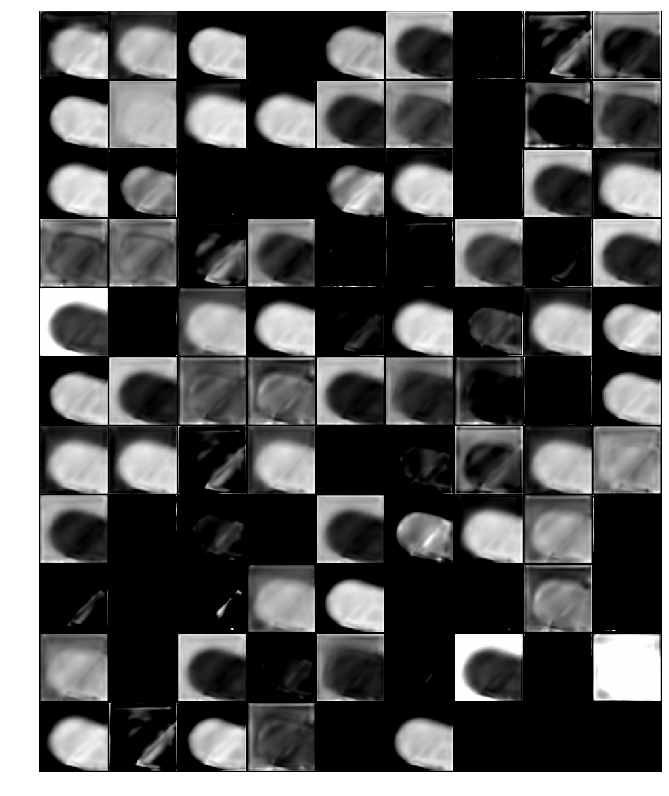

Layer: PixelShuffle_ICNR(
  (conv): Sequential(
    (0): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (shuf): PixelShuffle(upscale_factor=2)
  (pad): ReplicationPad2d((1, 0, 1, 0))
  (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (relu): ReLU(inplace)
)
Output shape: torch.Size([96, 1, 200, 200])


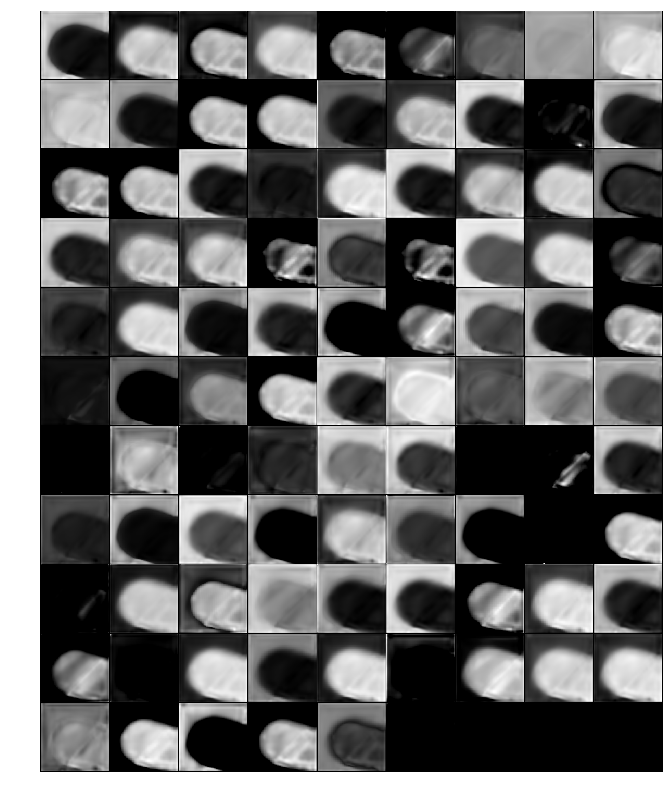

Layer: Conv2d(96, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
Output shape: torch.Size([6, 1, 200, 200])


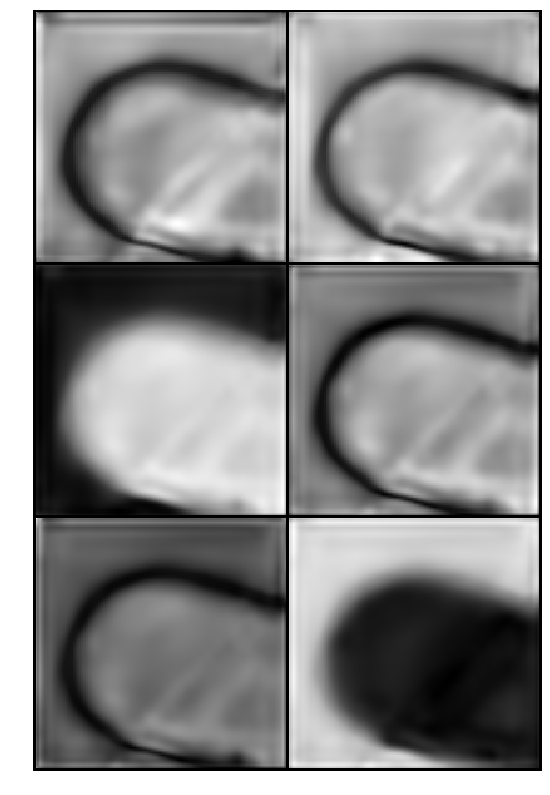

Layer: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([6, 1, 200, 200])


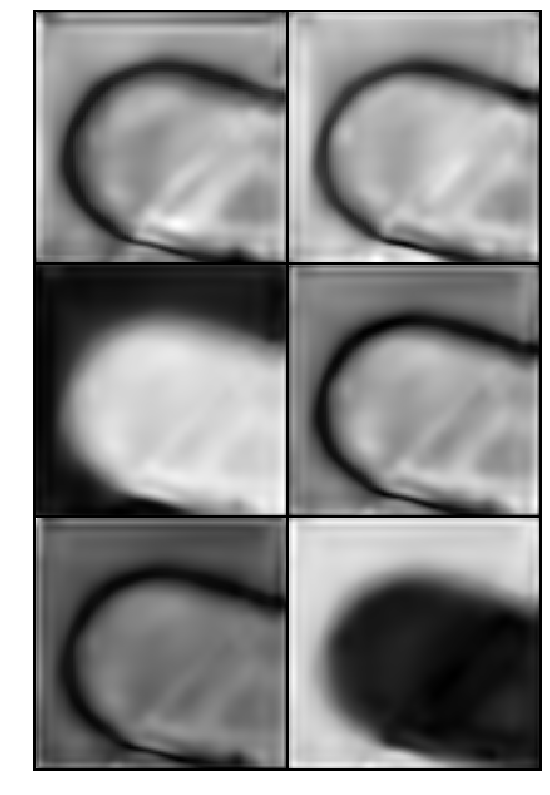


------------------------------------------- Final prediction -------------------------------------------



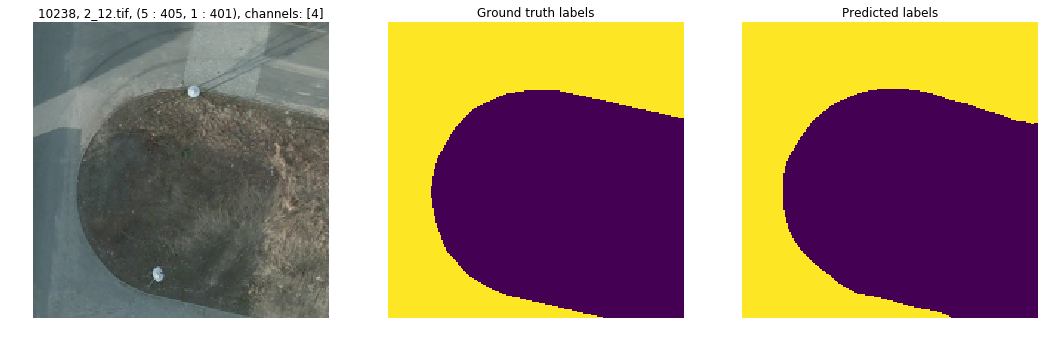

In [45]:
import itertools

def print_conv_layer_output(module, input, output):
    fs = output.detach().cpu().permute(1, 0, 2, 3)

    print('Layer:', module)
    print('Output shape:', fs.shape)

    normalize = not (fs.shape[-1] == 1 and fs.shape[-2] == 1)
    grid = tv.utils.make_grid(fs, nrow=int(len(fs)**0.5), normalize=normalize, scale_each=normalize, padding=2).permute(1, 2, 0)

    plt.figure(figsize=(14, 14))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.show()
    
def attach_hooks(m, callback, depth=0, max_depth=3):
    if depth > max_depth:
        return []

    hs = []
    for c in m.children():
        if isinstance(c, (nn.Sequential, nn.ModuleList)):
            hs += attach_hooks(c, callback, depth=depth+1)
        else:
            hs.append(c.register_forward_hook(callback))
    return hs

def model_debug(model, original_ds, val_ds, val_idx, flatten_seqs=False, channels=channels):

    im, label = original_ds[val_idx]
    im_rgb = im.permute(1, 2, 0)[..., :3].squeeze()
    im_input = im.permute(1, 2, 0)[..., channels].squeeze()
    
    im_idx, row, col = original_ds._to_chip_idx(val_idx)
    c_sz = original_ds.chip_size
    fname = f'{original_ds.fnames[im_idx]}.tif'

    print('\n------------------------------------------- Input image -------------------------------------------\n')
    f = plt.figure(figsize=(18, 6))
    ax1 = f.add_subplot(131)
    ax1.imshow(im_rgb)
    ax1.set_title(f'{val_idx}, {fname}, ({row} : {row + c_sz}, {col} : {col + c_sz}), channels: {channels}')
    ax1.axis('off')

    ax2 = f.add_subplot(132)
    ax2.imshow(im_input)
    ax2.set_title(f'Model input')
    ax2.axis('off')

    ax3 = f.add_subplot(133)
    ax3.imshow(label)
    ax3.set_title(f'Ground truth labels')
    ax3.axis('off')
    plt.show()

    print('\n------------------------------------------- Layer-wise output -------------------------------------------\n')
    
    # attach hooks to each layer
    hs = attach_hooks(model, print_conv_layer_output)
#     hs = []
#     model.apply(lambda m: hs.append(m.register_forward_hook(print_conv_layer_output)))
    
    val_im = val_ds[val_idx][0].unsqueeze(0).cuda()
    model.eval()
    with torch.no_grad():
        out = model(val_im)

    for h in hs:
        h.remove()

    print('\n------------------------------------------- Final prediction -------------------------------------------\n')
    yhat = out.cpu().squeeze().permute(1, 2, 0).argmax(dim=-1)
    
    f = plt.figure(figsize=(18, 6))
    ax1 = f.add_subplot(131)
    ax1.imshow(im_rgb)
    ax1.set_title(f'{val_idx}, {fname}, ({row} : {row + c_sz}, {col} : {col + c_sz}), channels: {channels}')
    ax1.axis('off')

    ax2 = f.add_subplot(132)
    ax2.imshow(label)
    ax2.set_title(f'Ground truth labels')
    ax2.axis('off')

    ax3 = f.add_subplot(133)
    ax3.imshow(yhat)
    ax3.set_title(f'Predicted labels')
    ax3.axis('off')
    plt.show()


val_idx = next(val_iter)
model_debug(model, original, val_ds, val_idx, channels=channels)

In [0]:
list(model.modules())[3]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [0]:
val_idx = next(val_iter)
val_im = val_ds[val_idx][0].unsqueeze(0).cuda()
model.eval()
with torch.no_grad():
    model(val_im)

In [0]:
# model

In [0]:
def IoU_mask(p, gt):
    union = (p | gt).sum()
    intersection = (p & gt).sum()
    return (intersection.float() / union)

def IoU(prediction, ground_truth, nclasses):
    IoUs = torch.ones(nclasses)
    for c in range(nclasses):
        if (ground_truth == c).sum() == 0:
            continue
        IoUs[c] = IoU_mask(prediction == c, ground_truth == c)
    return IoUs.mean(), IoUs

In [0]:
# (((yhat == 1) & (y == 1)).sum() / ((yhat == 1) | (y == 1)).sum()).float()
IoU(yhat, y , 6)

(tensor(0.9917), tensor([1.0000, 0.9798, 0.9823, 1.0000, 1.0000, 0.9881]))

In [0]:
a = torch.rand(5, 5)
a

tensor([[0.0669, 0.9288, 0.3481, 0.6761, 0.9364],
        [0.1722, 0.2730, 0.5518, 0.2167, 0.9278],
        [0.3848, 0.9313, 0.1895, 0.8670, 0.7182],
        [0.4242, 0.7600, 0.3189, 0.4011, 0.3781],
        [0.8114, 0.6697, 0.9234, 0.5852, 0.0508]])

In [0]:
a.trace() == a.diag().sum()

tensor(1, dtype=torch.uint8)

In [0]:
torch.diag(a) == a.diag()

tensor([1, 1, 1, 1, 1], dtype=torch.uint8)